In [1]:
'''predictor level fusion'''
import load_data
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time

#load data
training_data = load_data.read_data("train.csv")
testing_data = load_data.read_data("test.csv")
testing_labels = load_data.read_data("submission.csv")
X_train, X_test = load_data.vectorize_data(training_data, testing_data)

Y_train = np.array(training_data)[:, -1]
Y_test = np.array(testing_labels)[:, -1]
#load data -- pca data
X_train_pca = np.load('X_train_PCA.npy')
X_test_pca = np.load('X_test_PCA.npy')
#load data -- fld data
X_train_fld=np.load('X_train_FLD.npy')
X_test_fld=np.load('X_test_FLD.npy')


In [2]:
#Kmeans
def kmean(X_train,Y_train,X_test):
    print("kmean")
    kmean = KMeans(n_clusters=2)
    kmean.fit(X_train, Y_train)
    Y_train_kmean = kmean.predict(X_train)
    Y_pred_kmean = kmean.predict(X_test)
    return Y_train_kmean,Y_pred_kmean

In [3]:
#knn
def knn(X_train,Y_train,X_test):
    print("knn")
    knn = KNeighborsClassifier(n_neighbors=15,p=1)
    knn.fit(X_train, Y_train)
    Y_train_knn = knn.predict(X_train)
    Y_pred_knn = knn.predict(X_test)
    return Y_train_knn,Y_pred_knn

In [4]:
#random forest
def rf(X_train,Y_train,X_test):
    print("rf")
    rf = RandomForestClassifier(max_depth=None, bootstrap= True)
    rf.fit(X_train, Y_train)
    Y_train_fr = rf.predict(X_train)
    Y_pred_rf = rf.predict(X_test)
    return Y_train_fr,Y_pred_rf

In [5]:
#svm
def svm(X_train,Y_train,X_test):
    print("svm")
    svm = SVC()
    svm.fit(X_train, Y_train)

    Y_train_svm = svm.predict(X_train)
    Y_pred_smv = svm.predict(X_test)
    return Y_train_svm,Y_pred_smv

In [6]:
#bpnn
def bpnn(X_train,Y_train,X_test):
    print("bpnn")
    bpnn = MLPClassifier(hidden_layer_sizes = (100,10), max_iter=1000)
    bpnn.fit(X_train, Y_train)
    Y_train_bpnn = bpnn.predict(X_train)
    Y_pred_bpnn = bpnn.predict(X_test)
    return Y_train_bpnn,Y_pred_bpnn

In [7]:
def performance(Y_pred, Y_test):
    precision, recall, fscore, train_support = score(Y_test, Y_pred, pos_label=1, average='binary')
    print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(fscore,3), round(acs(Y_test,Y_pred), 3)))

    cm = confusion_matrix(Y_test, Y_pred)
    class_label = [0, 1]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    return 0

In [8]:
#fusion: majority voting
def mv(X_test_fusion,Y_test):
    t0 = time.time()
    Y_pred_mv = np.greater(np.sum(X_test_fusion, axis = 1),1).astype(int)
    t1 = time.time()
    print(f"run time: {t1-t0:.3f}")
    performance(Y_pred_mv,Y_test)
    return 0

In [9]:
#fusion: naive bayes
def nb(X_train_fusion,Y_train,X_test_fusion,Y_test):
    from sklearn.naive_bayes import GaussianNB
    gnb = GaussianNB()
    t0 = time.time()
    Y_pred_nb = gnb.fit(X_train_fusion, Y_train).predict(X_test_fusion)
    t1 = time.time()
    print(f"run time: {t1-t0:.3f}")
    performance(Y_pred_nb,Y_test)
    return 0

In [10]:
def fusion_data(X_train,Y_train,X_test,Y_test):
    Y_train_kmean, Y_pred_kmean = kmean(X_train_pca, Y_train, X_test_pca)
    Y_train_knn, Y_pred_knn = knn(X_train_pca, Y_train, X_test_pca)
    Y_train_fr, Y_pred_rf = rf(X_train_pca, Y_train, X_test_pca)
    Y_train_svm, Y_pred_smv = svm(X_train_pca, Y_train, X_test_pca)
    Y_train_bpnn, Y_pred_bpnn = bpnn(X_train_pca, Y_train, X_test_pca)
    X_train_fusion = np.vstack((Y_train_kmean,Y_train_knn,Y_train_fr,Y_train_svm,Y_train_bpnn)).T
    X_train_fusion = X_train_fusion.astype(int, copy=False)
    X_test_fusion = np.vstack((Y_pred_kmean,Y_pred_knn,Y_pred_rf,Y_pred_smv,Y_pred_bpnn)).T
    X_test_fusion = X_test_fusion.astype(int, copy=False)
    Y_train = Y_train.astype(int, copy=False)
    Y_test = Y_test.astype(int, copy=False)
    return X_train_fusion,Y_train,X_test_fusion,Y_test

svm
bpnn
run time: 0.000
Precision: 0.876 / Recall: 0.606 / F1-Score: 0.716 / Accuracy: 0.794


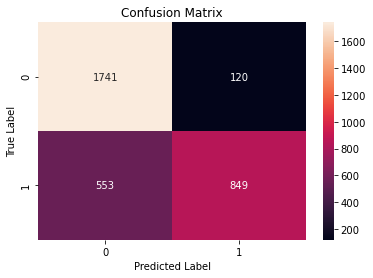

run time: 0.003
Precision: 0.718 / Recall: 0.689 / F1-Score: 0.703 / Accuracy: 0.75


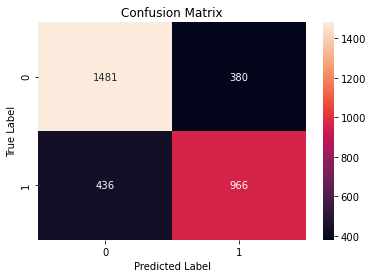

0

In [11]:
# pca + fusion
#X_train_fusion,Y_train,X_test_fusion,Y_test = fusion_data(X_train_pca,Y_train,X_test_pca,Y_test)

#Y_train_kmean, Y_pred_kmean = kmean(X_train_pca, Y_train, X_test_pca)
#Y_train_knn, Y_pred_knn = knn(X_train_pca, Y_train, X_test_pca)
#Y_train_rf, Y_pred_rf = rf(X_train_pca, Y_train, X_test_pca)
Y_train_svm, Y_pred_smv = svm(X_train_pca, Y_train, X_test_pca)
Y_train_bpnn, Y_pred_bpnn = bpnn(X_train_pca, Y_train, X_test_pca)
X_train_fusion = np.vstack((Y_train_svm,Y_train_bpnn)).T
X_train_fusion = X_train_fusion.astype(int, copy=False)
X_test_fusion = np.vstack((Y_pred_smv,Y_pred_bpnn)).T
X_test_fusion = X_test_fusion.astype(int, copy=False)
Y_train = Y_train.astype(int, copy=False)
Y_test = Y_test.astype(int, copy=False)

mv(X_test_fusion,Y_test)
nb(X_train_fusion,Y_train,X_test_fusion,Y_test)

svm
bpnn
run time: 0.000
Precision: 0.699 / Recall: 0.638 / F1-Score: 0.667 / Accuracy: 0.726


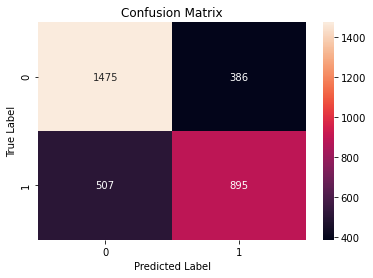

run time: 0.002
Precision: 0.664 / Recall: 0.677 / F1-Score: 0.67 / Accuracy: 0.714


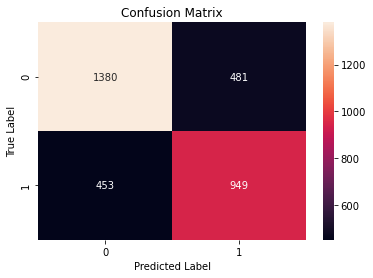

0

In [10]:
# fld + fusion
#X_train_fusion,Y_train,X_test_fusion,Y_test = fusion_data(X_train_pca,Y_train,X_test_pca,Y_test)

#Y_train_kmean, Y_pred_kmean = kmean(X_train_pca, Y_train, X_test_pca)
#Y_train_knn, Y_pred_knn = knn(X_train_pca, Y_train, X_test_pca)
#Y_train_rf, Y_pred_rf = rf(X_train_pca, Y_train, X_test_pca)
Y_train_svm1, Y_pred_smv1 = svm(X_train_fld, Y_train, X_test_fld)
Y_train_bpnn1, Y_pred_bpnn1 = bpnn(X_train_fld, Y_train, X_test_fld)
X_train_fusion1 = np.vstack((Y_train_svm1,Y_train_bpnn1)).T
X_train_fusion1 = X_train_fusion1.astype(int, copy=False)
X_test_fusion1 = np.vstack((Y_pred_smv1,Y_pred_bpnn1)).T
X_test_fusion1 = X_test_fusion1.astype(int, copy=False)
Y_train = Y_train.astype(int, copy=False)
Y_test = Y_test.astype(int, copy=False)

mv(X_test_fusion1,Y_test)
nb(X_train_fusion1,Y_train,X_test_fusion1,Y_test)

In [ ]:
#fusion: logistic regression
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
Y_pred_lgr = lgr.fit(X_train_fusion, Y_train).predict(X_test_fusion)

performance(Y_pred_lgr)

Precision: 0.826 / Recall: 0.666 / F1-Score: 0.737 / Accuracy: 0.796


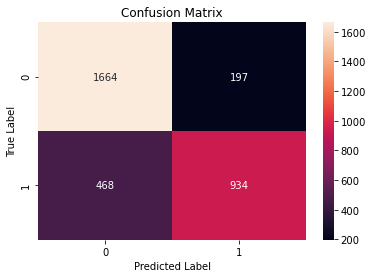

0

In [57]:
#fusion: random forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
Y_pred_rfc = rfc.fit(X_train_fusion, Y_train).predict(X_test_fusion)

performance(Y_pred_rfc)

Precision: 0.826 / Recall: 0.665 / F1-Score: 0.737 / Accuracy: 0.796


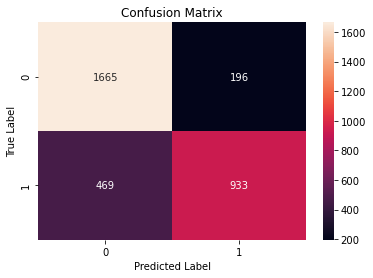

0

In [58]:
#fusion: gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
Y_pred_gb = gb.fit(X_train_fusion,Y_train).predict(X_test_fusion)

performance(Y_pred_gb)